In [ ]:
!pip install -U accelerate
!pip install -U transformers
!pip install hdbscan
!pip install numpy<2 scikit-learn<1.4 scipy<2 transformers<5

In [ ]:
!pip install 'numpy<2'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import torch
from transformers import DistilBertTokenizer, AutoTokenizer
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss
import numpy as np
from transformers import EvalPrediction
from transformers import TrainingArguments, Trainer
import pickle

In [2]:
df_train = pd.read_csv('TrainCombine.csv')
df_test = pd.read_csv('test_set.csv')

In [3]:
df_train

,Technique,ID,Tactic-Name,Technique-Name,SubTechnique-Name,Platforms,Description,id
0,T1482,No sub-Techniques,Discovery,Domain Trust Discovery,No sub-Technique,Windows,AdFind can gather information about organizati...,T1482
1,T1482,No sub-Techniques,Discovery,Domain Trust Discovery,No sub-Technique,Windows,BADHATCH can use nltest.exe /domain_trusts to ...,T1482
2,T1482,No sub-Techniques,Discovery,Domain Trust Discovery,No sub-Technique,Windows,Bazar can use Nltest tools to obtain informati...,T1482
3,T1482,No sub-Techniques,Discovery,Domain Trust Discovery,No sub-Technique,Windows,"During C0015, the threat actors used the comma...",T1482
4,T1482,No sub-Techniques,Discovery,Domain Trust Discovery,No sub-Technique,Windows,Earth Lusca has used Nltest to obtain informat...,T1482
...,...,...,...,...,...,...,...,...
56558,T1658,No sub-Techniques,Execution,Exploitation for Client Execution,No sub-Technique,NaN,Malicious actors leverage vulnerabilities in ...,T1658
56559,T1658,No sub-Techniques,Execution,Exploitation for Client Execution,No sub-Technique,NaN,Cybercriminals exploit flaws in online dating...,T1658
56560,T1658,No sub-Techniques,Execution,Exploitation for Client Execution,No sub-Technique,NaN,Threat actors use infected codec packs to exp...,T1658
56561,T1658,No sub-Techniques,Execution,Exploitation for Client Execution,No sub-Technique,NaN,Attackers exploit weaknesses in mobile device...,T1658


In [4]:
df_test

,Technique,ID,Tactic-Name,Technique-Name,SubTechnique-Name,Platforms,Description,id
0,T1018,No sub-Techniques,Discovery,Remote System Discovery,No sub-Technique,"Linux, Network, Windows, macOS","During the 2015 Ukraine Electric Power Attack,...",T1018
1,T1123,No sub-Techniques,Collection,Audio Capture,No sub-Technique,"Linux, Windows, macOS",MacSpy can record the sounds from microphones ...,T1123
2,T1057,No sub-Techniques,Discovery,Process Discovery,No sub-Technique,"Linux, Network, Windows, macOS",Cuba can enumerate processes running on a vict...,T1057
3,T1105,No sub-Techniques,Command and Control,Ingress Tool Transfer,No sub-Technique,"Linux, Windows, macOS",Octopus can download additional files and tool...,T1105
4,T1041,No sub-Techniques,Exfiltration,Exfiltration Over C2 Channel,No sub-Technique,"Linux, Windows, macOS",SILENTTRINITY can transfer files from an infec...,T1041
...,...,...,...,...,...,...,...,...
3343,T1437,T1437.001,Command and Control,Application Layer Protocol,Web Protocols,NaN,Exobot has used HTTPS for C2 communication.,T1437.001
3344,T1521,T1521.002,Command and Control,Encrypted Channel,Asymmetric Cryptography,NaN,FluBot has encrypted C2 message bodies with RS...,T1521.002
3345,T1629,T1629.001,Defense Evasion,Impair Defenses,Prevent Application Removal,NaN,FluBot can use Accessibility Services to make ...,T1629.001
3346,T1629,T1629.001,Defense Evasion,Impair Defenses,Prevent Application Removal,NaN,Gustuff may prevent application removal by abu...,T1629.001


In [5]:
merged_df = pd.concat([df_train,df_test])

In [6]:
merged_df

,Technique,ID,Tactic-Name,Technique-Name,SubTechnique-Name,Platforms,Description,id
0,T1482,No sub-Techniques,Discovery,Domain Trust Discovery,No sub-Technique,Windows,AdFind can gather information about organizati...,T1482
1,T1482,No sub-Techniques,Discovery,Domain Trust Discovery,No sub-Technique,Windows,BADHATCH can use nltest.exe /domain_trusts to ...,T1482
2,T1482,No sub-Techniques,Discovery,Domain Trust Discovery,No sub-Technique,Windows,Bazar can use Nltest tools to obtain informati...,T1482
3,T1482,No sub-Techniques,Discovery,Domain Trust Discovery,No sub-Technique,Windows,"During C0015, the threat actors used the comma...",T1482
4,T1482,No sub-Techniques,Discovery,Domain Trust Discovery,No sub-Technique,Windows,Earth Lusca has used Nltest to obtain informat...,T1482
...,...,...,...,...,...,...,...,...
3343,T1437,T1437.001,Command and Control,Application Layer Protocol,Web Protocols,NaN,Exobot has used HTTPS for C2 communication.,T1437.001
3344,T1521,T1521.002,Command and Control,Encrypted Channel,Asymmetric Cryptography,NaN,FluBot has encrypted C2 message bodies with RS...,T1521.002
3345,T1629,T1629.001,Defense Evasion,Impair Defenses,Prevent Application Removal,NaN,FluBot can use Accessibility Services to make ...,T1629.001
3346,T1629,T1629.001,Defense Evasion,Impair Defenses,Prevent Application Removal,NaN,Gustuff may prevent application removal by abu...,T1629.001


In [8]:
merged_df=pd.read_csv('Final_Dataset.csv')
merged_df.head()

,Unnamed: 0,Description,id,Tactic-Name,Technique-Name,SubTechnique-Name
0,0.0,It spreads to Microsoft Windows machines using...,T1210,Lateral Movement,Exploitation of Remote Services,No sub-Technique
1,1.0,"Once a machine is infected by NotPetya, a seri...",T1570,Lateral Movement,Lateral Tool Transfer,No sub-Technique
2,2.0,Ransomware DLL C:\windows\perfc.dat,T1140,Defense Evasion,Deobfuscate/Decode Files or Information,No sub-Technique
3,3.0,The malware decompresses its resource named 0x...,T1140,Defense Evasion,Deobfuscate/Decode Files or Information,No sub-Technique
4,4.0,C:\windows\dllhost.dat Credential theft module...,T1059.003,Execution,Command and Scripting Interpreter,Windows Command Shell


In [9]:
merged_df.shape
merged_df.info()

merged_df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64953 entries, 0 to 64952
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5143 non-null   float64
 1   Description        64953 non-null  object 
 2   id                 64953 non-null  object 
 3   Tactic-Name        63583 non-null  object 
 4   Technique-Name     63583 non-null  object 
 5   SubTechnique-Name  63583 non-null  object 
dtypes: float64(1), object(5)
memory usage: 3.0+ MB


0

In [10]:
merged_df.drop_duplicates(inplace=True)

In [11]:
merged_df.duplicated().sum()

0

In [12]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64953 entries, 0 to 64952
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5143 non-null   float64
 1   Description        64953 non-null  object 
 2   id                 64953 non-null  object 
 3   Tactic-Name        63583 non-null  object 
 4   Technique-Name     63583 non-null  object 
 5   SubTechnique-Name  63583 non-null  object 
dtypes: float64(1), object(5)
memory usage: 3.0+ MB


In [13]:
# To remove the 'Platforms' column
merged_df.drop(columns=['Platforms','Technique','ID'], inplace=True)

KeyError: "['Platforms', 'Technique', 'ID'] not found in axis"

In [14]:
merged_df.head()

,Unnamed: 0,Description,id,Tactic-Name,Technique-Name,SubTechnique-Name
0,0.0,It spreads to Microsoft Windows machines using...,T1210,Lateral Movement,Exploitation of Remote Services,No sub-Technique
1,1.0,"Once a machine is infected by NotPetya, a seri...",T1570,Lateral Movement,Lateral Tool Transfer,No sub-Technique
2,2.0,Ransomware DLL C:\windows\perfc.dat,T1140,Defense Evasion,Deobfuscate/Decode Files or Information,No sub-Technique
3,3.0,The malware decompresses its resource named 0x...,T1140,Defense Evasion,Deobfuscate/Decode Files or Information,No sub-Technique
4,4.0,C:\windows\dllhost.dat Credential theft module...,T1059.003,Execution,Command and Scripting Interpreter,Windows Command Shell


In [15]:
# This will give a boolean result for each column (True if NaN is present)
print(merged_df.isna().any())

Unnamed: 0            True
Description          False
id                   False
Tactic-Name           True
Technique-Name        True
SubTechnique-Name     True
dtype: bool


In [16]:
# This will show the count of NaNs in each column
print(merged_df.isna().sum())

Unnamed: 0           59810
Description              0
id                       0
Tactic-Name           1370
Technique-Name        1370
SubTechnique-Name     1370
dtype: int64


In [22]:
# Display rows with NaN in any of the specified columns
nan_rows = merged_df[merged_df[['Tactic-Name', 'Technique-Name', 'SubTechnique-Name']].isna().any(axis=1)]
print(nan_rows)

                                            Description     id Tactic-Name  \
22    For each client, the following occurs: Obtains...  T1016         NaN   
23    For each client, the following occurs: Obtains...  T1078         NaN   
26    UNC Write to Admin$ WNetAddConnection2W is use...  T1078         NaN   
31    The malware takes the following steps to modif...  T1027         NaN   
34    Sector 34 contains the original MBR that was e...  T1027         NaN   
...                                                 ...    ...         ...   
5106  This is based on the following factors: Malwar...  T1027         NaN   
5118  Process Injection: Process Hollowing T1055.012...  T1055         NaN   
5120  [TA0005] Technique Title ID Use Obfuscated Fil...  T1027         NaN   
5121  Obfuscated Files or Information: Software Pack...  T1027         NaN   
5130  System Network Configuration Discovery T1016 T...  T1016         NaN   

     Technique-Name SubTechnique-Name  
22              NaN    

In [23]:
# Get unique 'id' values where any of 'Tactic-Name', 'Technique-Name', or 'SubTechnique-Name' are NaN
unique_ids_any_nan = merged_df[merged_df[['Tactic-Name', 'Technique-Name', 'SubTechnique-Name']].isna().any(axis=1)]['id'].unique()
print(unique_ids_any_nan)

['T1016' 'T1078' 'T1027' 'T1055' 'T1090' 'T1110']


In [36]:
def check_ids_existence(df, ids_to_check):
    # Check if the ids exist in the DataFrame
    ids_exist = df['id'].isin(ids_to_check)
    
    # Separate the ids that exist and those that don't
    ids_found = df.loc[ids_exist, 'id'].unique()
    ids_not_found = list(set(ids_to_check) - set(ids_found))
    
    # Return the results
    return ids_found, ids_not_found

# List of ids to check
ids_to_check = ['T1055.001', 'T1055.002', 'T1055.003', 'T1055.004', 'T1055.005', 
                'T1055.008', 'T1055.009', 'T1055.011', 'T1055.012', 'T1055.013', 
                'T1055.014', 'T1055.015']

# Call the function and get the results
ids_found, ids_not_found = check_ids_existence(merged_df, ids_to_check)

# Print the results
print(f"IDs found in the DataFrame: {ids_found}")
print(f"IDs not found in the DataFrame: {ids_not_found}")

IDs found in the DataFrame: ['T1055.015' 'T1055.011' 'T1055.004' 'T1055.001' 'T1055.003' 'T1055.013'
 'T1055.005' 'T1055.002' 'T1055.012']
IDs not found in the DataFrame: ['T1055.009', 'T1055.014', 'T1055.008']


In [37]:
# List of 'id's to check (new set of IDs you want to check)
ids_to_check_new = [
    'T1027.001', 'T1027.002', 'T1027.003', 'T1027.004', 'T1027.005', 
    'T1027.006', 'T1027.007', 'T1027.008', 'T1027.009', 'T1027.010', 
    'T1027.011', 'T1027.012', 'T1027.013', 'T1027.014'
]

# Call the function and get the results
ids_found_new, ids_not_found_new = check_ids_existence(merged_df, ids_to_check_new)

# Print the results
print(f"IDs found in the DataFrame: {ids_found_new}")
print(f"IDs not found in the DataFrame: {ids_not_found_new}")

IDs found in the DataFrame: ['T1027.004' 'T1027.010' 'T1027.011' 'T1027.009' 'T1027.006' 'T1027.001'
 'T1027.005' 'T1027.008' 'T1027.003' 'T1027.007' 'T1027.002']
IDs not found in the DataFrame: ['T1027.013', 'T1027.014', 'T1027.012']


In [46]:
# Check if the particular 'id' exists in the DataFrame
id_to_check = 'T1016.002'
id_exists = merged_df['id'].isin([id_to_check]).any()
print(f"Does ID {id_to_check} exist? {id_exists}")

Does ID T1016.002 exist? True


In [47]:
manual_data = {
    'T1016': {
        'Tactic-Name': 'Discovery',
        'Technique-Name': 'System Network Configuration Discovery',
        'SubTechnique-Name': 'No sub-Technique'
    },
    'T1078': {
        'Tactic-Name': 'Defense Evasion, Persistence, Privilege Escalation, Initial Access',
        'Technique-Name': 'Valid Accounts',
        'SubTechnique-Name': 'No sub-Technique'
    },
    'T1027': {
        'Tactic-Name': 'Defense Evasion',
        'Technique-Name': 'Obfuscated Files or Information',
        'SubTechnique-Name': 'No sub-Technique'
    },
    'T1055': {
        'Tactic-Name': 'Defense Evasion, Privilege Escalation',
        'Technique-Name': 'Process Injection',
        'SubTechnique-Name': 'No sub-Technique'
    },
    'T1090': {
        'Tactic-Name': 'Command and Control',
        'Technique-Name': 'Proxy',
        'SubTechnique-Name': 'No sub-Technique'
    },
    'T1110': {
        'Tactic-Name': 'Credential Access',
        'Technique-Name': 'Brute Force',
        'SubTechnique-Name': 'No sub-Technique'
    }
}

# Check if the 'id' column exists
if 'id' in merged_df.columns:
    # Loop through the manual data and update the rows for missing IDs
    for id_value, data in manual_data.items():
        if id_value in merged_df['id'].values:
            # Use .loc to update the rows for the specific id
            merged_df.loc[merged_df['id'] == id_value, ['Tactic-Name', 'Technique-Name', 'SubTechnique-Name']] = \
                data['Tactic-Name'], data['Technique-Name'], data['SubTechnique-Name']
        else:
            # If the ID does not exist in the DataFrame, you can choose to add it
            new_row = pd.DataFrame({
                'id': [id_value],
                'Tactic-Name': [data['Tactic-Name']],
                'Technique-Name': [data['Technique-Name']],
                'SubTechnique-Name': [data['SubTechnique-Name']]
            })
            merged_df = pd.concat([merged_df, new_row], ignore_index=True)

# Display the updated DataFrame
print(merged_df[merged_df['id'].isin(manual_data.keys())])

                                            Description     id  \
22    For each client, the following occurs: Obtains...  T1016   
23    For each client, the following occurs: Obtains...  T1078   
26    UNC Write to Admin$ WNetAddConnection2W is use...  T1078   
31    The malware takes the following steps to modif...  T1027   
34    Sector 34 contains the original MBR that was e...  T1027   
...                                                 ...    ...   
5106  This is based on the following factors: Malwar...  T1027   
5118  Process Injection: Process Hollowing T1055.012...  T1055   
5120  [TA0005] Technique Title ID Use Obfuscated Fil...  T1027   
5121  Obfuscated Files or Information: Software Pack...  T1027   
5130  System Network Configuration Discovery T1016 T...  T1016   

                                            Tactic-Name  \
22                                            Discovery   
23    Defense Evasion, Persistence, Privilege Escala...   
26    Defense Evasion, Persist

In [49]:
# Check if any value in the DataFrame is NaN
any_na = merged_df.isna().any().any()

# Check for columns that have NaN values
columns_with_na = merged_df.columns[merged_df.isna().any()].tolist()

# Check how many NaN values in each column
nan_count_per_column = merged_df.isna().sum()

# Print the results
print(f"Does the DataFrame have any NaN values? {any_na}")
print(f"Columns with NaN values: {columns_with_na}")
print(f"NaN values count per column:\n{nan_count_per_column}")

Does the DataFrame have any NaN values? False
Columns with NaN values: []
NaN values count per column:
Description          0
id                   0
Tactic-Name          0
Technique-Name       0
SubTechnique-Name    0
dtype: int64


In [58]:
merged_df.to_csv('Final_Dataset.csv',index=False)

In [51]:
merged_df

,Description,id,Tactic-Name,Technique-Name,SubTechnique-Name
0,It spreads to Microsoft Windows machines using...,T1210,Lateral Movement,Exploitation of Remote Services,No sub-Technique
1,"Once a machine is infected by NotPetya, a seri...",T1570,Lateral Movement,Lateral Tool Transfer,No sub-Technique
2,Ransomware DLL C:\windows\perfc.dat,T1140,Defense Evasion,Deobfuscate/Decode Files or Information,No sub-Technique
3,The malware decompresses its resource named 0x...,T1140,Defense Evasion,Deobfuscate/Decode Files or Information,No sub-Technique
4,C:\windows\dllhost.dat Credential theft module...,T1059.003,Execution,Command and Scripting Interpreter,Windows Command Shell
...,...,...,...,...,...
64948,Exobot has used HTTPS for C2 communication.,T1437.001,Command and Control,Application Layer Protocol,Web Protocols
64949,FluBot has encrypted C2 message bodies with RS...,T1521.002,Command and Control,Encrypted Channel,Asymmetric Cryptography
64950,FluBot can use Accessibility Services to make ...,T1629.001,Defense Evasion,Impair Defenses,Prevent Application Removal
64951,Gustuff may prevent application removal by abu...,T1629.001,Defense Evasion,Impair Defenses,Prevent Application Removal


In [52]:
merged_df['Labels'] = merged_df[['Tactic-Name', 'Technique-Name', 'SubTechnique-Name', 'id']].agg(', '.join, axis=1)

In [53]:
merged_df['Labels']

0        Lateral Movement, Exploitation of Remote Servi...
1        Lateral Movement, Lateral Tool Transfer, No su...
2        Defense Evasion, Deobfuscate/Decode Files or I...
3        Defense Evasion, Deobfuscate/Decode Files or I...
4        Execution, Command and Scripting Interpreter, ...
                               ...                        
64948    Command and Control, Application Layer Protoco...
64949    Command and Control, Encrypted Channel, Asymme...
64950    Defense Evasion, Impair Defenses, Prevent Appl...
64951    Defense Evasion, Impair Defenses, Prevent Appl...
64952    Command and Control, Web Service, Dead Drop Re...
Name: Labels, Length: 64921, dtype: object

In [54]:
merged_df

,Description,id,Tactic-Name,Technique-Name,SubTechnique-Name,Labels
0,It spreads to Microsoft Windows machines using...,T1210,Lateral Movement,Exploitation of Remote Services,No sub-Technique,"Lateral Movement, Exploitation of Remote Servi..."
1,"Once a machine is infected by NotPetya, a seri...",T1570,Lateral Movement,Lateral Tool Transfer,No sub-Technique,"Lateral Movement, Lateral Tool Transfer, No su..."
2,Ransomware DLL C:\windows\perfc.dat,T1140,Defense Evasion,Deobfuscate/Decode Files or Information,No sub-Technique,"Defense Evasion, Deobfuscate/Decode Files or I..."
3,The malware decompresses its resource named 0x...,T1140,Defense Evasion,Deobfuscate/Decode Files or Information,No sub-Technique,"Defense Evasion, Deobfuscate/Decode Files or I..."
4,C:\windows\dllhost.dat Credential theft module...,T1059.003,Execution,Command and Scripting Interpreter,Windows Command Shell,"Execution, Command and Scripting Interpreter, ..."
...,...,...,...,...,...,...
64948,Exobot has used HTTPS for C2 communication.,T1437.001,Command and Control,Application Layer Protocol,Web Protocols,"Command and Control, Application Layer Protoco..."
64949,FluBot has encrypted C2 message bodies with RS...,T1521.002,Command and Control,Encrypted Channel,Asymmetric Cryptography,"Command and Control, Encrypted Channel, Asymme..."
64950,FluBot can use Accessibility Services to make ...,T1629.001,Defense Evasion,Impair Defenses,Prevent Application Removal,"Defense Evasion, Impair Defenses, Prevent Appl..."
64951,Gustuff may prevent application removal by abu...,T1629.001,Defense Evasion,Impair Defenses,Prevent Application Removal,"Defense Evasion, Impair Defenses, Prevent Appl..."


In [55]:
merged_df.drop(columns=['Tactic-Name', 'Technique-Name', 'SubTechnique-Name', 'id'], inplace=True)

In [56]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64921 entries, 0 to 64952
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  64921 non-null  object
 1   Labels       64921 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [57]:
merged_df.duplicated().sum()

0

<Axes: ylabel='Frequency'>

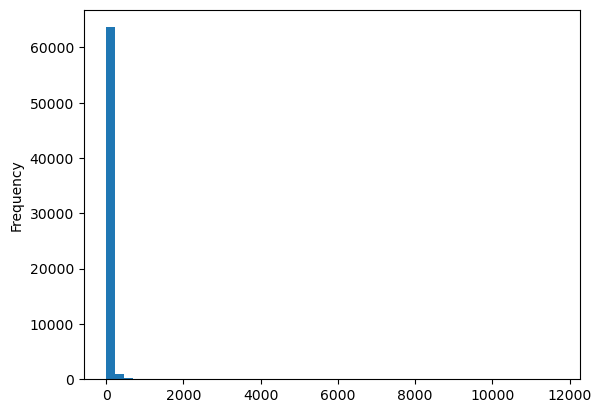

In [10]:
merged_df['Description'].str.len().plot.hist(bins=50)

In [13]:
# Calculate the maximum length of the descriptions
max_length = merged_df['Description'].str.len().max()

# Print the maximum length
print(f"The maximum length of descriptions is: {max_length}")

The maximum length of descriptions is: 11672


In [14]:
count_max_length = (merged_df['Description'].str.len() == max_length).sum()
print(f"Number of descriptions with the maximum length ({max_length}): {count_max_length}")

Number of descriptions with the maximum length (11672): 1


In [15]:
average_length = merged_df['Description'].str.len().mean()
print(f"The average length of descriptions is: {average_length:.2f}")

The average length of descriptions is: 98.94


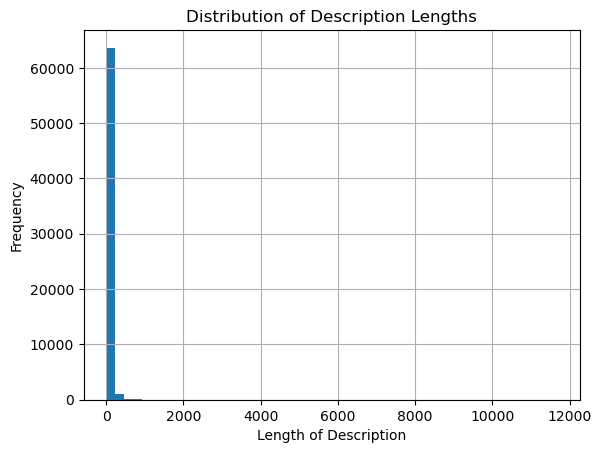

In [16]:
# Plot the distribution of description lengths
merged_df['Description'].str.len().hist(bins=50)
plt.xlabel('Length of Description')
plt.ylabel('Frequency')
plt.title('Distribution of Description Lengths')
plt.show()

In [59]:
merged_df['Labels'] = merged_df['Labels'].str.split(',')

In [60]:
merged_df['Labels'].value_counts()

Labels
[Defense Evasion,  Deobfuscate/Decode Files or Information,  No sub-Technique,  T1140]                                              706
[Command and Control,  Ingress Tool Transfer,  No sub-Technique,  T1105]                                                            693
[Defense Evasion,  Obfuscated Files or Information,  No sub-Technique,  T1027]                                                      678
[Execution,  Command and Scripting Interpreter,  Windows Command Shell,  T1059.003]                                                 676
[Discovery,  System Information Discovery,  No sub-Technique,  T1082]                                                               481
                                                                                                                                   ... 
[Exfiltration,  Exfiltration Over Other Network Medium,  Exfiltration Over Bluetooth,  T1011.001]                                    90
[ Persistence,  Privilege Escalation,  De

In [61]:
label_counts = [lab for label in merged_df['Labels'] for lab in label]

In [62]:
pd.Series(label_counts).value_counts()

 No sub-Technique                      21953
Defense Evasion                        13322
 Privilege Escalation                   8605
 Persistence                            7640
 Defense Evasion                        5936
                                       ...  
 KernelCallbackTable                      89
 T1574.009                                84
 Path Interception by Unquoted Path       84
 T1110                                    52
 T1016                                    52
Name: count, Length: 1151, dtype: int64

In [63]:
multilabel = MultiLabelBinarizer()

In [64]:
labels = multilabel.fit_transform(merged_df['Labels']).astype('float32')

In [65]:
texts = merged_df['Description'].tolist()

In [66]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [67]:
texts

['It spreads to Microsoft Windows machines using several propagation methods, including the EternalBlue exploit for the CVE-2017-0144 vulnerability in the SMB service.',
 'Once a machine is infected by NotPetya, a series of malicious activities ensue, including the following: Dropped files Process hashes and process privilege checks Credential theft Token impersonation Malware propagation Network node enumeration SMB copy and remote execution SMBv1 exploitation via EternalBlue UNC write malware to admin$ on remote target Remote execution of the malware MBR ransomware Physical drive manipulation MFT encryption File encryption System shutdown Anti-forensics Ransomware instructions for file recovery occur after the infection process has completed.',
 'Ransomware DLL C:\\windows\\perfc.dat ',
 'The malware decompresses its resource named 0x3 of type RT_RCDATA, and writes the contents to C:\\Windows\\dllhost.dat.',
 'C:\\windows\\dllhost.dat Credential theft module Written as a .tmp file to

In [68]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [69]:
checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint, num_labels=len(labels[0]),problem_type="multi_label_classification")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
class CustomDataset(Dataset):
    def __init__(self,texts,labels,tokenizer,max_len=128):
        self.texts=texts
        self.labels=labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = torch.tensor(self.labels[idx])

        encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
        return {
        'input_ids':encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': label
        }

In [71]:
train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer)

In [72]:
train_dataset[0]

{'input_ids': tensor([  101, 24391,  3049, 21155,  2015,  1012, 11163,  6764,  2000,  8116,
         16540,  8059, 18093,  2015,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [73]:
def multi_labels_metrics(predictions, labels, threshold = 0.3):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))

    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs>=threshold)] = 1
    y_true = labels

    f1 = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_pred, average='macro')
    hamming = hamming_loss(y_true, y_pred)

    metrics = {
    "roc_auc": roc_auc,
    "hamming_loss": hamming,
    "f1": f1
    }

    return metrics

In [74]:
def compute_metrics(p:EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    
    result = multi_labels_metrics(predictions=preds, labels=p.label_ids)

    return result

In [75]:
args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir='./results',
    num_train_epochs=6,  # Adjusted to match the completed epochs
    learning_rate=4.1179021008724044e-05,  # Based on final learning trends
    warmup_ratio=0.037418867019853155,  # Keep the same as earlier
    weight_decay=0.058733689490454315,  # Keep the same as earlier
    evaluation_strategy="epoch",  # Replace deprecated 'eval_strategy'
    logging_dir='./logs',  # Optional, for TensorBoard logs
    save_total_limit=2,  # Save only the best 2 checkpoints  # Automatically load the best model
)

/home/aiml/anaconda3/envs/rapids-24.10/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [76]:
trainer = Trainer(model=model, args=args, train_dataset=train_dataset, eval_dataset=val_dataset, compute_metrics=compute_metrics)

In [77]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc,Hamming Loss,F1,Runtime,Samples Per Second,Steps Per Second
1,0.013400,0.012216,0.511807,0.002986,0.025961,38.761200,502.487000,62.821000
2,0.007100,0.006242,0.649704,0.001949,0.325116,38.734400,502.834000,62.864000
3,0.003800,0.003950,0.866187,0.001180,0.747838,38.355000,507.809000,63.486000
4,0.002300,0.003202,0.927748,0.000978,0.843568,39.925300,487.836000,60.989000
5,0.001600,0.002853,0.939971,0.000853,0.870798,38.747800,502.661000,62.842000
6,0.001200,0.002839,0.942929,0.000813,0.879806,38.741500,502.742000,62.852000


TrainOutput(global_step=34086, training_loss=0.011388736299788777, metrics={'train_runtime': 1457.1852, 'train_samples_per_second': 187.117, 'train_steps_per_second': 23.392, 'total_flos': 9214799817259008.0, 'train_loss': 0.011388736299788777, 'epoch': 6.0})

In [78]:
trainer.evaluate()

{'eval_loss': 0.002839390654116869,
 'eval_roc_auc': 0.942928520198188,
 'eval_hamming_loss': 0.0008130510325462628,
 'eval_f1': 0.8798059519342422,
 'eval_runtime': 38.4454,
 'eval_samples_per_second': 506.614,
 'eval_steps_per_second': 63.337,
 'epoch': 6.0}

In [79]:
trainer.save_model('distilbert-finedtuned')

In [80]:
tokenizer.save_pretrained('distilbert-finedtuned')

('distilbert-finedtuned/tokenizer_config.json',
 'distilbert-finedtuned/special_tokens_map.json',
 'distilbert-finedtuned/vocab.txt',
 'distilbert-finedtuned/added_tokens.json')

In [81]:
with open("multilabel_binarizer.pkl","wb") as f:
    pickle.dump(multilabel, f)

In [82]:
import pickle
from transformers import AutoTokenizer

# Save the tokenizer using pickle
with open('tokenizer_best.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Tokenizer saved successfully.")


Tokenizer saved successfully.


In [ ]:
!zip -r disltilbert.zip "distilbert-finetuned"

In [ ]:
text = "Exploit Public- Facing Application SVR frequently uses publicly available exploits to conduct widespread exploitation of vulnerable systems, including against Citrix, Pulse Secure, FortiGate, Zimbra and VMWare." #add testing text

encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)

In [ ]:
text = "Active Scanning SVR frequently scans for publicly available exploits, most recently including Microsoft Exchange servers vulnerable to CVE-2021- 26855. " #add testing text

encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)

In [83]:
text = "In one example identified by the NCSC, the actor had searched for authentication credentials in mailboxes, including passwords and PKI keys" #add testing text

encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)

In [84]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs.logits[0].cpu())
preds = np.zeros(probs.shape)
preds[np.where(probs>=0.3)] = 1

In [85]:
preds

array([0., 0., 0., ..., 0., 0., 0.])

In [86]:
multilabel.classes_

array([' /etc/passwd and /etc/shadow', ' ARP Cache Poisoning',
       ' AS-REP Roasting', ..., 'Privilege Escalation', 'Reconnaissance',
       'Resource Development'], dtype=object)

In [87]:
multilabel.inverse_transform(preds.reshape(1,-1))

[(' Credentials In Files',
  ' T1552.001',
  ' Unsecured Credentials',
  'Credential Access')]